In [1]:
import os
import sys
import random

from pathlib import Path
root = Path('..').resolve()
sys.path.insert(0, str(root))

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

from train_config import transform_prep
from image_processing import adversarial_erase, normalize_image_to_range, convert_to_np_array
from data_utils import load_and_transform_image

/Users/andrea/miniconda3/envs/pl-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
def load_heatmap(base_heatmaps_dir, iteration, img_path: str) -> torch.Tensor:
    heatmap_path = os.path.join(
        base_heatmaps_dir, 
        f"iteration_{iteration}", 
        os.path.basename(img_path) + ".pt"
    )
    if os.path.exists(heatmap_path):
        # print(f"HEATMAP FOUND: {heatmap_path}")
        return torch.load(heatmap_path)
    else:
        print(f"HEATMAP NOT FOUND: {heatmap_path}")
        # Use a random heatmap if the heatmap is not found
        return torch.load(random.choice(self.heatmap_files))
    
def load_matching_heatmap(base_heatmaps_dir, iteration, img_path: str) -> torch.Tensor:
    img_basename = os.path.basename(img_path)[:6]  # First 6 characters
    iteration_dir = os.path.join(
        base_heatmaps_dir, 
        f"iteration_{iteration}"
    )

    matching_files = [
        file for file in os.listdir(iteration_dir)
        if file.startswith(img_basename) and file.endswith(".pt")
    ]

    if matching_files:
        heatmap_path = os.path.join(
            iteration_dir,
            random.choice(matching_files)
        )
        # print(f"HEATMAP FOUND: {heatmap_path}")
        return torch.load(heatmap_path)
    
    # Fall back to a random heatmap from the iteration directory
    heatmap_files = [
        os.path.join(iteration_dir, file) 
        for file in os.listdir(iteration_dir) if file.endswith(".pt")
    ]
    if heatmap_files:
        print(f"HEATMAP NOT FOUND, but found in iteration dir: {heatmap_path}")
        return torch.load(random.choice(heatmap_files))

    # Final fallback to any random heatmap if no files exist in the 
    # iteration folder
    print(f"HEATMAP NOT FOUND, not even in iteration dir: {heatmap_path}")
    return torch.load(random.choice(self.heatmap_files))


def overlay_heatmap(
    image, heatmap: np.ndarray, alpha: float = 0.5
) -> np.ndarray:
    # Convert image to NumPy array and normalize
    img_np = normalize_image_to_range(convert_to_np_array(image), target_range=(0, 255))

    # Resize the heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))

    # Convert heatmap from grayscale (1 channel) to RGB (3 channels)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET) # Apply color map to heatmap
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) # Convert color space from BGR (Blue, Green, Red) to RGB

    # Overlay the heatmap on the image
    ov_img = cv2.addWeighted(heatmap_colored, alpha, img_np, 1 - alpha, 0)

    # Smooth overlay using the heatmap values (Transparency)
    heatmap_resized = np.repeat(heatmap_resized[:, :, np.newaxis], 3, axis=2) # Repeat the heatmap values across 3 channels
    ov_smooth_img = (ov_img * heatmap_resized + img_np * (1 - heatmap_resized)).astype(np.uint8) # Smooth overlay

    return normalize_image_to_range(ov_smooth_img, target_range=(0, 1))

HEATMAP NOT FOUND: /Users/andrea/Documents/thesis_temp/heatmaps/iteration_0/0ee435_20190308T142434_20190308T142620_mos_rgb.png.pt


NameError: name 'self' is not defined

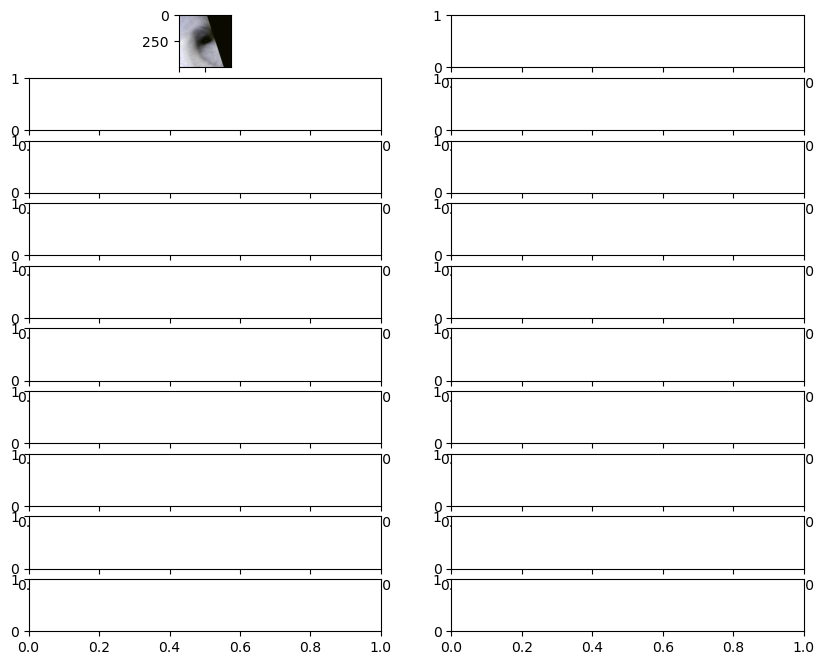

In [5]:
base_heatmaps_dir = os.path.expanduser(
    "~/Documents/thesis_temp/heatmaps/"
)
image_filename = '0ee435_20190308T142434_20190308T142620_mos_rgb.png'
image_label = 1 # 1 -> pos, 0 -> neg

fig, axs = plt.subplots(10, 2, figsize=(10, 8))

num_iterations = 10
for i in range(num_iterations):
    img = load_and_transform_image(root / 'data' / 'train' / 'pos' / image_filename, transform_prep)
    if i > 0:
        # Initialize the accumulated heatmap to all zeros. When the 
        # current image is negative, load_heatmap will not find the 
        # corresponding heatmap, and it will use a random heatmap 
        # instead. This is fine since the size of the heatmap is 
        # always the same.
        accumulated_heatmap = torch.zeros_like(
            load_heatmap(base_heatmaps_dir, i-1, image_filename)
        )
    
        # Iterate from 0 to current iteration (excluded)
        for it in range(i):
            if image_label == 1:  # Positive sample: use its own heatmap
                heatmap = load_heatmap(base_heatmaps_dir, it, image_filename)
            else:  # Negative sample: use a random heatmap
                print(f'Trying to find a matching heatmap for {img_path} and iteration {it}')
                heatmap = load_matching_heatmap(base_heatmaps_dir, it, img_path)
    
            accumulated_heatmap += heatmap
        
        # Normalize the accumulated heatmap to keep values between 0 
        # and 1
        accumulated_heatmap = torch.clamp(accumulated_heatmap, 0, 1)

        threshold = 0.7
        fill_color = 0
        img = adversarial_erase(
            img, 
            accumulated_heatmap,
            threshold=threshold,
            fill_color=fill_color
        )

    axs[i, 0].imshow(normalize_image_to_range(img.squeeze(0).permute(1, 2, 0).cpu().numpy()))
    axs[i, 1].imshow(overlay_heatmap(img, load_heatmap(base_heatmaps_dir, i, image_filename).cpu().numpy()))

    if image_label == 1:  # Positive sample: use its own heatmap
        heatmap = load_heatmap(base_heatmaps_dir, i, image_filename)
    else:  # Negative sample: use a random heatmap
        print(f'Trying to find a matching heatmap for {img_path} and iteration {it}')
        heatmap = load_matching_heatmap(base_heatmaps_dir, i, img_path)

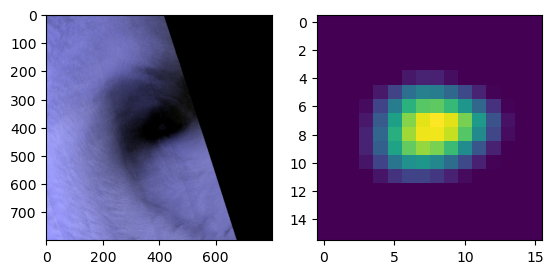

In [17]:
# Create two subplots
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(tens)
plt.show()

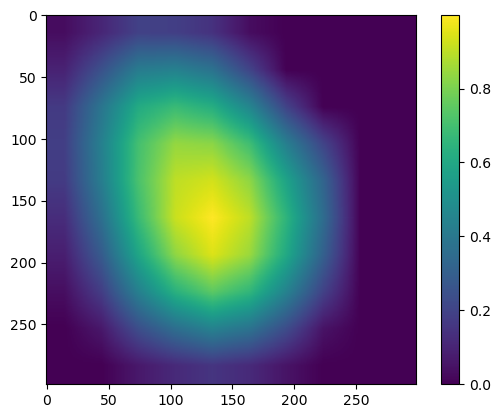

In [ ]:
import torchvision.transforms.functional as TF

tens_resized = TF.resize(tens.unsqueeze(0), (500, 500), antialias=True)

plt.imshow(tens_resized.squeeze(0))
plt.colorbar()
plt.show()

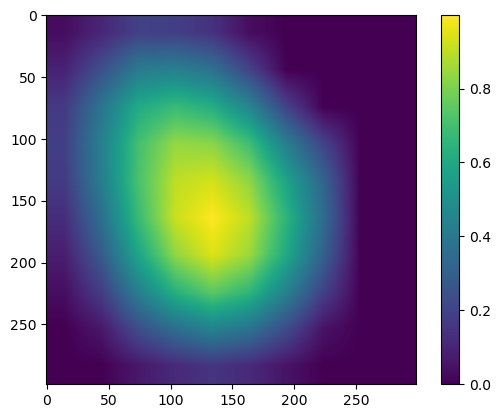

In [ ]:
tens_resized = TF.resize(tens.unsqueeze(0), (299, 299), antialias=False)

plt.imshow(tens_resized.squeeze(0))
plt.colorbar()
plt.show()